<h2 align='center'> MINI-PROJECT-1 </h2>

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# importing essential libraries and modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import  train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

## Analysing Training Set :

In [55]:
# load training set 
train = pd.read_csv("/content/drive/MyDrive/technocolabs training set.csv")
train.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4,5,6,7,14,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(218586, 21)

- It has 218586 rows and 21 attributes 

In [56]:
train.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1.0,20.0,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0.0,0.0,0.0,0.0,0.0,0.0,True,16.0,7/15/2018,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2.0,20.0,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0.0,1.0,0.0,0.0,0.0,0.0,True,16.0,7/15/2018,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3.0,20.0,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0.0,1.0,0.0,0.0,0.0,0.0,True,16.0,7/15/2018,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4.0,20.0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0.0,1.0,0.0,0.0,0.0,0.0,True,16.0,7/15/2018,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5.0,20.0,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0.0,1.0,0.0,0.0,0.0,0.0,True,16.0,7/15/2018,True,editorial_playlist,trackdone,trackdone


In [57]:
# Information of training set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218586 entries, 0 to 218585
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   session_id                       167881 non-null  object 
 1   session_position                 167880 non-null  float64
 2   session_length                   167880 non-null  float64
 3   track_id_clean                   167880 non-null  object 
 4   skip_1                           167880 non-null  object 
 5   skip_2                           167880 non-null  object 
 6   skip_3                           167880 non-null  object 
 7   not_skipped                      167880 non-null  object 
 8   context_switch                   167880 non-null  float64
 9   no_pause_before_play             167880 non-null  float64
 10  short_pause_before_play          167880 non-null  float64
 11  long_pause_before_play           167880 non-null  float64
 12  hi

- There are 9 float atttributes and 12 object attributes
- As from the data we can see, skip_1, skip_2 and some more coulmns are in  boolean(True or False) but it is counting as object so in pre-processing step we weill change the datatype 
- There are many null values 

### Statistical summary 

In [58]:
train.describe()

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hour_of_day
count,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000
mean,9.325911,17.651823,0.040904,0.767602,0.146635,0.172832,0.038909,0.046259,14.193084
std,5.457638,3.422025,0.198069,0.422363,0.353742,0.378103,0.367295,0.606558,5.996243
min,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,15.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000
50%,9.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,15.000000
75%,14.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.000000
max,20.000000,20.000000,1.000000,1.000000,1.000000,1.000000,60.000000,151.000000,23.000000


In [59]:
# summary for objects columns
train.describe(include=['O'])

,session_id,track_id_clean,skip_1,skip_2,skip_3,not_skipped,hist_user_behavior_is_shuffle,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
count,167881,167880,167880,167880,167880,167880,167880,167880,167880,167880,167880,167880
unique,10001,50704,2,2,2,2,2,18,2,6,9,7
top,0_09fd07ff-577c-4499-8d87-74ada734f106,t_bacf06d3-9185-4183-84ea-ff0db51475ce,False,True,True,False,False,7/15/2018,True,user_collection,fwdbtn,fwdbtn
freq,20,1427,97118,86824,108850,111996,116050,119639,136053,67430,79912,81389


### Data-preprocessing and EDA

In [60]:
# droping duplicates and null values : 
train.drop_duplicates(inplace=True)
train.dropna(inplace=True)
train.shape

(167880, 21)

In [61]:
# changing the type of columns 
for colname in ['skip_1','skip_2','skip_3','not_skipped','hist_user_behavior_is_shuffle','premium']:
    train[colname] = train[colname].astype(int, copy=False)

### Creating target column

In [62]:
train['skip'] = train['not_skipped'].replace({ 0 : 1, 1 : 0 })

In [63]:
train['skip'].value_counts()

1    111996
0     55884
Name: skip, dtype: int64

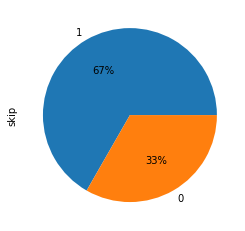

In [64]:
train['skip'].value_counts().plot(kind='pie', autopct = "%1.0f%%")

### Analysing categorical data

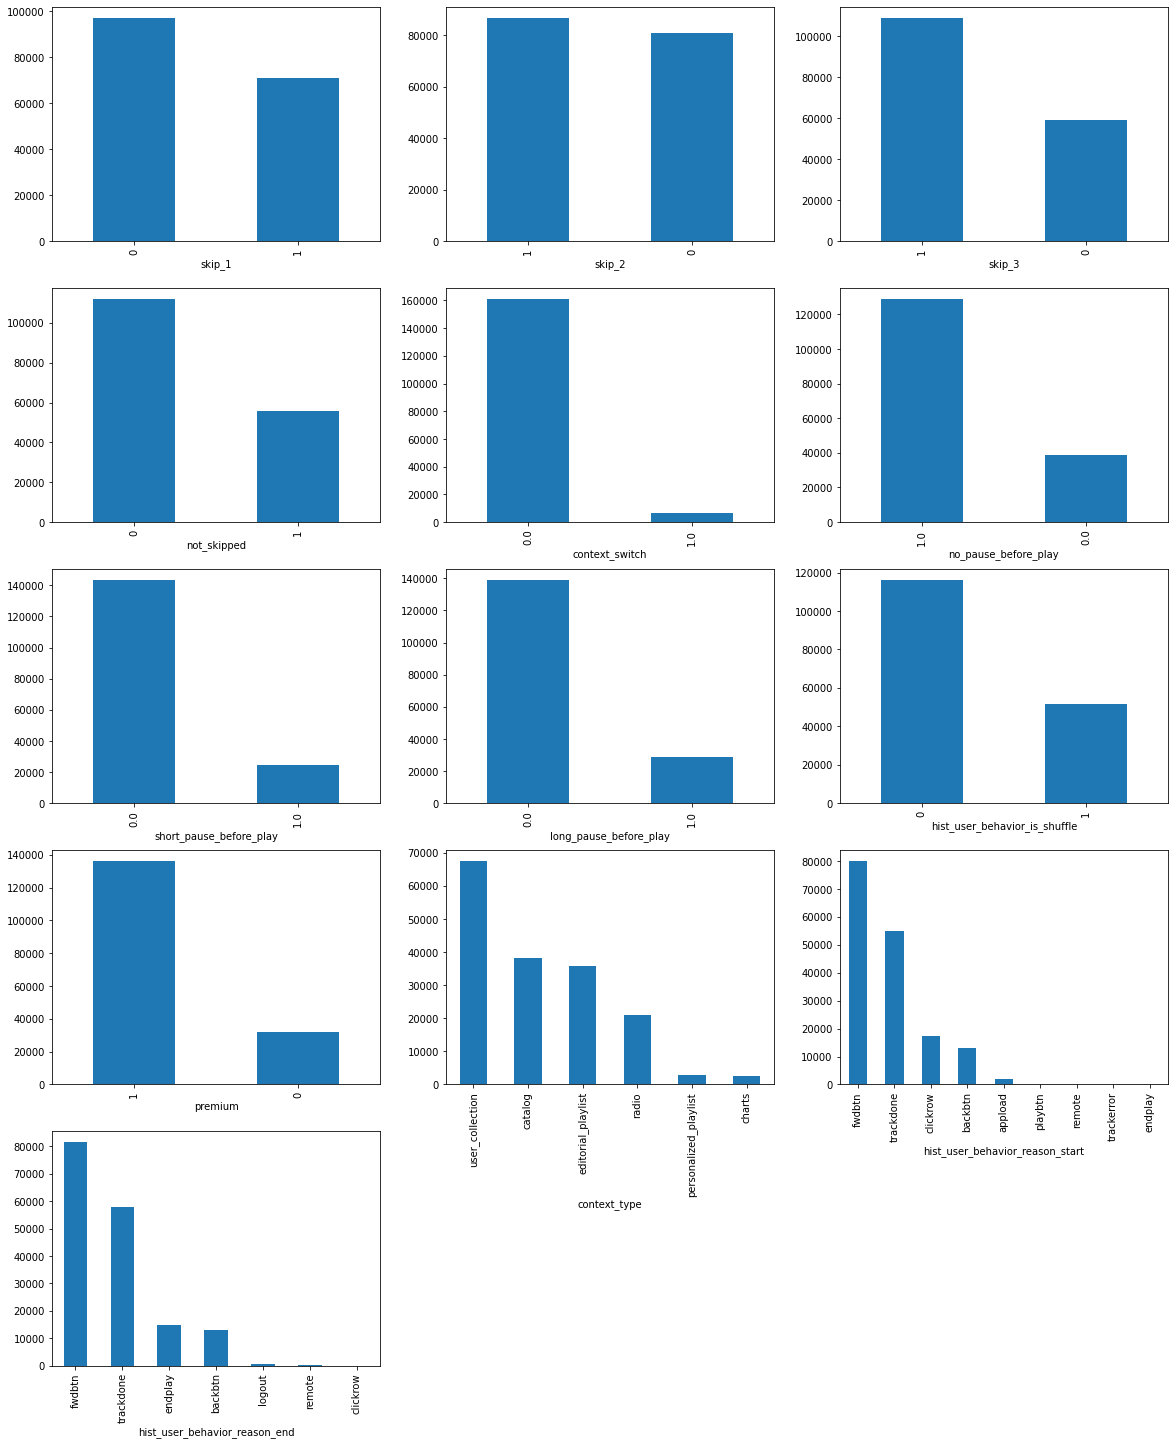

In [65]:
col = ['skip_1','skip_2','skip_3',
       'not_skipped','context_switch','no_pause_before_play',
       'short_pause_before_play','long_pause_before_play','hist_user_behavior_is_shuffle',
       'premium','context_type','hist_user_behavior_reason_start',
       'hist_user_behavior_reason_end']

plt.figure(figsize=(20,25))
n = 1
for colname in col:
    plt.subplot(5,3,n)
    train[colname].value_counts().plot(kind='bar')
    plt.xlabel(colname)
    n +=1

In [66]:
# creating copy of the train data 
df = train.copy()
df.shape

(167880, 22)

In [67]:
# df.date = df.date.apply(pd.to_datetime)
# df.info()

### Dropping Irrelevent columns

In [68]:
df = df.drop(columns=['skip_1','skip_2','skip_3','not_skipped','date'])
df.shape

(167880, 17)

In [69]:
df.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,skip
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1.0,20.0,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.0,0.0,0.0,0.0,0.0,0.0,1,16.0,1,editorial_playlist,trackdone,trackdone,0
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2.0,20.0,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,editorial_playlist,trackdone,trackdone,0
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3.0,20.0,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,editorial_playlist,trackdone,trackdone,0
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4.0,20.0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,editorial_playlist,trackdone,trackdone,0
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5.0,20.0,t_64f3743c-f624-46bb-a579-0f3f9a07a123,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,editorial_playlist,trackdone,trackdone,0


### One-hot Encoding on Train data

In [70]:
df1 = df.drop(['session_id', 'track_id_clean'], axis=1)
df1.shape

(167880, 15)

In [71]:
dummy_train = pd.get_dummies(df1)
dummy_train.shape

(167880, 34)

In [72]:
dummy_train.head()

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,skip,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone
0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1,16.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,2.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,3.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,4.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,5.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


## Analysing Track Features 

In [73]:
# there are two different files of track features so the aim is to merge both of them then analyse data: 
tf = pd.read_csv('/content/drive/MyDrive/tf_000000000000.csv')
tf.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_2e8f4b71-8a0b-4b9c-b7d8-fb5208e87f9f,326.013336,1971,99.582885,0.716209,0.366495,0.332605,0.439835,5.805774,0.238847,1.010700,6.533861e-01,0,0.769258,-17.094,0.199170,major,0.759699,0.033940,100.370003,4,0.223395,0.146012,-0.706908,0.259496,0.481157,0.238427,-0.098389,-0.254960,-0.227383
1,t_dae2ec0e-ec7b-4b3e-b60c-4a884d0eccb0,147.813324,1963,97.272035,0.839460,0.362212,0.389829,0.507580,6.845427,0.420476,1.000398,3.941550e-09,0,0.085844,-11.295,0.357639,major,0.747436,0.049856,141.334000,4,0.484702,0.039554,-0.539554,0.105141,0.692589,0.226047,-0.468162,0.164389,-0.769024
2,t_cf0164dd-1531-4399-bfa6-dec19cd1fedc,110.400002,1974,99.620384,0.054673,0.495002,0.589378,0.552311,9.361949,0.842938,0.957766,1.041595e-01,0,0.407325,-9.310,0.304721,major,0.493154,0.071753,138.889999,4,0.818441,0.083863,-0.242108,-0.014258,0.096396,0.417641,-0.050576,-0.204757,-0.172563
3,t_0f90acc7-d5c5-4e53-901d-55610fbd090c,237.653336,1988,96.796830,0.042606,0.389634,0.359044,0.585673,6.068578,0.665398,0.947322,1.444963e-05,0,0.251502,-12.159,0.702948,major,0.212197,0.029425,133.139008,4,0.594829,0.192498,0.340039,0.034846,-0.389794,0.518381,0.185008,-0.079907,-0.016978
4,t_36b9ad02-095a-443d-a697-6c7285d9410a,174.600006,1987,97.905891,0.249982,0.513640,0.485435,0.635095,7.198735,0.408715,1.014063,5.266880e-01,0,0.218370,-13.813,0.888889,major,0.193438,0.032178,152.212006,4,0.591289,0.270586,-0.411061,0.165898,0.225652,0.335518,-0.036643,-0.016300,-0.446870


In [74]:
tf2 = pd.read_csv('/content/drive/MyDrive/tf_000000000001.csv')
tf2.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_8e88a9ea-1451-44ff-8fae-8bbad75b55c8,364.906677,1979,90.965232,0.851046,0.363622,0.300117,0.465182,5.150449,0.127037,1.054217,2.748115e-07,0,0.096354,-18.855,0.406516,major,0.733656,0.031645,132.020996,4,0.211844,0.042945,-0.433785,0.115645,0.456437,0.400481,-0.259629,-0.002503,-0.757088
1,t_65d18266-940a-4f27-9df5-fc9fee10b406,106.160004,1987,96.794376,0.250302,0.440026,0.414878,0.563041,6.605741,0.529062,0.962033,3.822885e-06,0,0.047301,-14.182,0.397906,major,0.461069,0.048545,126.434998,4,0.736954,-0.069781,-0.360500,0.170185,0.475511,0.501377,-0.199189,0.063746,-0.648822
2,t_59ef344c-10bc-415e-8a80-f97b46ee8bc8,275.906677,1985,98.495282,0.376435,0.659612,0.650850,0.696868,9.034748,0.378950,1.028740,1.942323e-03,0,0.112578,-13.783,0.376093,major,0.515249,0.027752,87.459999,4,0.703813,0.137408,-0.325600,0.162500,0.209357,0.556263,-0.047349,-0.201937,-0.722556
3,t_ba702bde-7de3-418f-95f6-5c1af618e28c,314.626678,1960,92.442730,0.710315,0.553800,0.617168,0.601151,9.409214,0.413531,1.009348,5.948958e-01,0,0.254762,-13.531,0.195933,major,0.758640,0.066143,118.060997,4,0.723693,0.461877,-1.031251,0.133070,0.653448,0.139172,-0.265598,-0.257693,-0.093790
4,t_96e1843d-312b-476d-9e31-ebb14bc478ff,323.133331,1990,96.715096,0.001014,0.318370,0.283095,0.331088,5.358051,0.759440,0.927291,7.619123e-04,0,0.082879,-11.208,0.422735,major,0.408188,0.057926,126.890999,4,0.418748,0.280588,0.362112,-0.345611,-0.461005,0.587766,0.128220,-0.172042,0.341655


In [75]:
# joining two dataframes : 
track = pd.concat([tf, tf2])
track.shape

(3706388, 30)

### Inspecting data

In [76]:
track.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3706388 entries, 0 to 1853076
Data columns (total 30 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   track_id                object 
 1   duration                float64
 2   release_year            int64  
 3   us_popularity_estimate  float64
 4   acousticness            float64
 5   beat_strength           float64
 6   bounciness              float64
 7   danceability            float64
 8   dyn_range_mean          float64
 9   energy                  float64
 10  flatness                float64
 11  instrumentalness        float64
 12  key                     int64  
 13  liveness                float64
 14  loudness                float64
 15  mechanism               float64
 16  mode                    object 
 17  organism                float64
 18  speechiness             float64
 19  tempo                   float64
 20  time_signature          int64  
 21  valence                 float64

- There are 25 float attrbutes, 2 object and 3 integer attributes 

In [77]:
track.duplicated().sum()

0

In [78]:
track.isna().sum()

track_id                  0
duration                  0
release_year              0
us_popularity_estimate    0
acousticness              0
beat_strength             0
bounciness                0
danceability              0
dyn_range_mean            0
energy                    0
flatness                  0
instrumentalness          0
key                       0
liveness                  0
loudness                  0
mechanism                 0
mode                      0
organism                  0
speechiness               0
tempo                     0
time_signature            0
valence                   0
acoustic_vector_0         0
acoustic_vector_1         0
acoustic_vector_2         0
acoustic_vector_3         0
acoustic_vector_4         0
acoustic_vector_5         0
acoustic_vector_6         0
acoustic_vector_7         0
dtype: int64

- There are no duplicate values 
- There are no null values in track_features dataframe

### Statistical summary of track features

In [79]:
track.describe()

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
count,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06
mean,2.331915e+02,2.009261e+03,9.557394e+01,3.469715e-01,4.617475e-01,4.791122e-01,5.565486e-01,7.848266e+00,5.918491e-01,9.934531e-01,2.070054e-01,5.272434e+00,2.126515e-01,-9.604988e+00,4.996207e-01,4.618936e-01,1.045310e-01,1.200684e+02,3.874560e+00,4.814764e-01,-1.044815e-01,1.553606e-02,5.953425e-02,5.320778e-02,2.273738e-02,6.459076e-04,-2.493560e-02,-1.594925e-03
std,1.084008e+02,1.103289e+01,2.735566e+00,3.426439e-01,1.717593e-01,1.990264e-01,1.858440e-01,2.680296e+00,2.602815e-01,5.521685e-02,3.447905e-01,3.564020e+00,1.924461e-01,5.732654e+00,2.561809e-01,2.509198e-01,1.385980e-01,3.042757e+01,4.851897e-01,2.725142e-01,4.323750e-01,3.607428e-01,2.804066e-01,3.821163e-01,4.107566e-01,2.118570e-01,3.742747e-01,3.871178e-01
min,3.000095e+01,1.950000e+03,9.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.174042e+00,-1.185975e+00,-8.858698e-01,-8.994451e-01,-1.081056e+00,-1.063290e+00,-8.022487e-01,-1.178501e+00
25%,1.767467e+02,2.006000e+03,9.338183e+01,2.667680e-02,3.316528e-01,3.206987e-01,4.326980e-01,5.821963e+00,4.098319e-01,9.691408e-01,2.465405e-07,2.000000e+00,9.680310e-02,-1.171000e+01,2.692308e-01,2.532349e-01,3.627243e-02,9.603400e+01,4.000000e+00,2.519543e-01,-4.085117e-01,-1.757177e-01,-1.471524e-01,-2.348342e-01,-3.122829e-01,-9.018810e-02,-3.155564e-01,-2.704680e-01
50%,2.179135e+02,2.013000e+03,9.575417e+01,2.205129e-01,4.593159e-01,4.795972e-01,5.727441e-01,7.519920e+00,6.261150e-01,1.002422e+00,2.161874e-04,5.000000e+00,1.294195e-01,-8.084000e+00,4.854369e-01,4.549237e-01,5.012670e-02,1.199480e+02,4.000000e+00,4.736025e-01,-4.000132e-02,8.460746e-02,1.291028e-01,6.207571e-02,-1.709655e-02,4.277601e-02,-9.838638e-02,-4.027091e-03
75%,2.671733e+02,2.017000e+03,9.792122e+01,6.528423e-01,5.851562e-01,6.339014e-01,6.975901e-01,9.476902e+00,8.073052e-01,1.029172e+00,3.132863e-01,8.000000e+00,2.700362e-01,-5.791000e+00,7.173145e-01,6.480055e-01,1.015356e-01,1.398600e+02,4.000000e+00,7.050039e-01,1.915962e-01,2.832876e-01,2.746523e-01,2.832823e-01,3.724048e-01,1.476096e-01,2.058770e-01,2.218316e-01
max,1.799999e+03,2.019000e+03,1.000000e+02,9.957964e-01,9.999525e-01,9.862775e-01,9.978067e-01,5.261309e+01,9.999841e-01,1.167801e+00,9.999964e-01,1.100000e+01,1.000000e+00,6.275000e+00,1.000000e+00,9.791129e-01,9.705799e-01,2.499870e+02,5.000000e+00,9.999900e-01,1.000457e+00,8.624035e-01,6.509755e-01,1.202726e+00,1.000955e+00,4.130149e-01,1.092165e+00,1.204228e+00


In [80]:
# summary for object columns:
track.describe(include='O')

,track_id,mode
count,3706388,3706388
unique,3706388,2
top,t_4e3be382-f13b-4a59-a52f-a6c85e96a31d,major
freq,1,2414637


### EDA 

In [81]:
# extracting columns other than float ie, int and object for eda :
tf[[c for c in tf.columns if tf[c].dtype != 'float64']].head()

,track_id,release_year,key,mode,time_signature
0,t_2e8f4b71-8a0b-4b9c-b7d8-fb5208e87f9f,1971,0,major,4
1,t_dae2ec0e-ec7b-4b3e-b60c-4a884d0eccb0,1963,0,major,4
2,t_cf0164dd-1531-4399-bfa6-dec19cd1fedc,1974,0,major,4
3,t_0f90acc7-d5c5-4e53-901d-55610fbd090c,1988,0,major,4
4,t_36b9ad02-095a-443d-a697-6c7285d9410a,1987,0,major,4


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


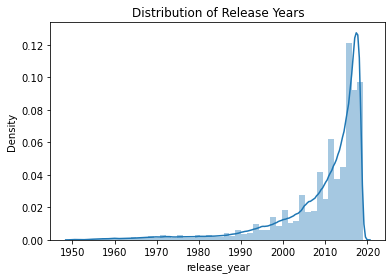

In [82]:
# distribution of release years : 
sns.distplot(track.release_year)
plt.title("Distribution of Release Years");

In [83]:
track['key'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

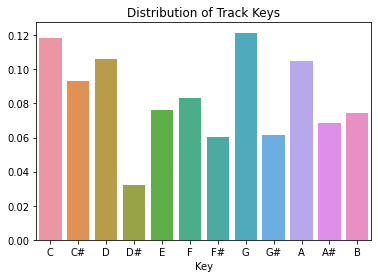

In [84]:
# we have unique values in keys columns: we have specific Pitch class for these keys(just naming keys acc. to their pitch class)
keys = track.key.value_counts().sort_index()
sns.barplot(
    x=[ "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"],
    y=keys.values/keys.sum()
)
plt.title("Distribution of Track Keys")
plt.xlabel("Key");

In [85]:
track['mode'].value_counts()

major    2414637
minor    1291751
Name: mode, dtype: int64

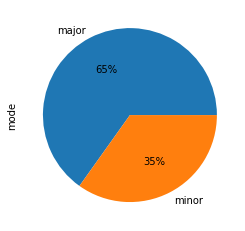

In [86]:
track['mode'].value_counts().plot(kind='pie', autopct = "%1.0f%%")

In [87]:
# creating label encoding/one hot encoding of mode column 
track['mode'] = track['mode'].replace({
    'major': 1,
    'minor': 0
})

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


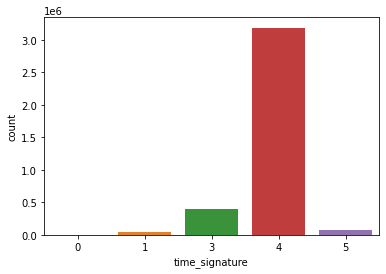

In [88]:
sns.countplot(track.time_signature)

### Analysing numerical columns

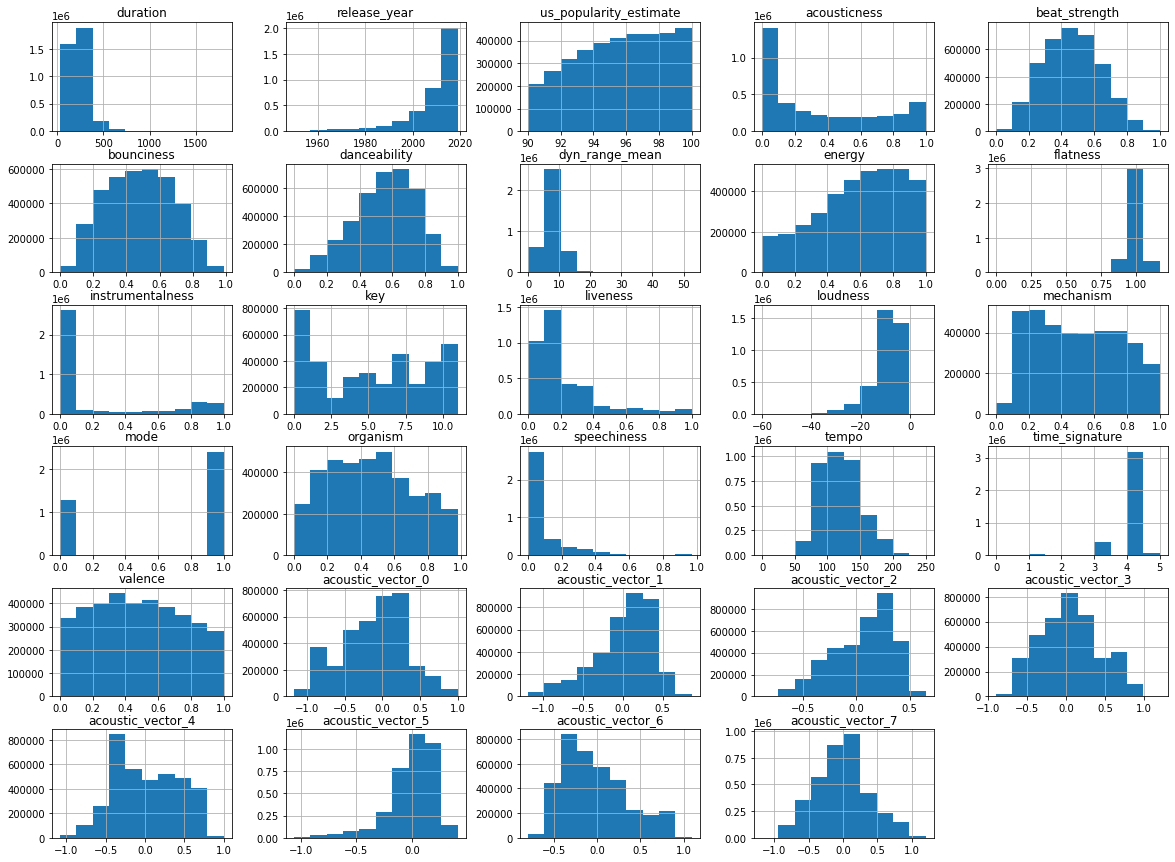

In [89]:
track.hist(figsize=(20,15));

### Correlation matrix  

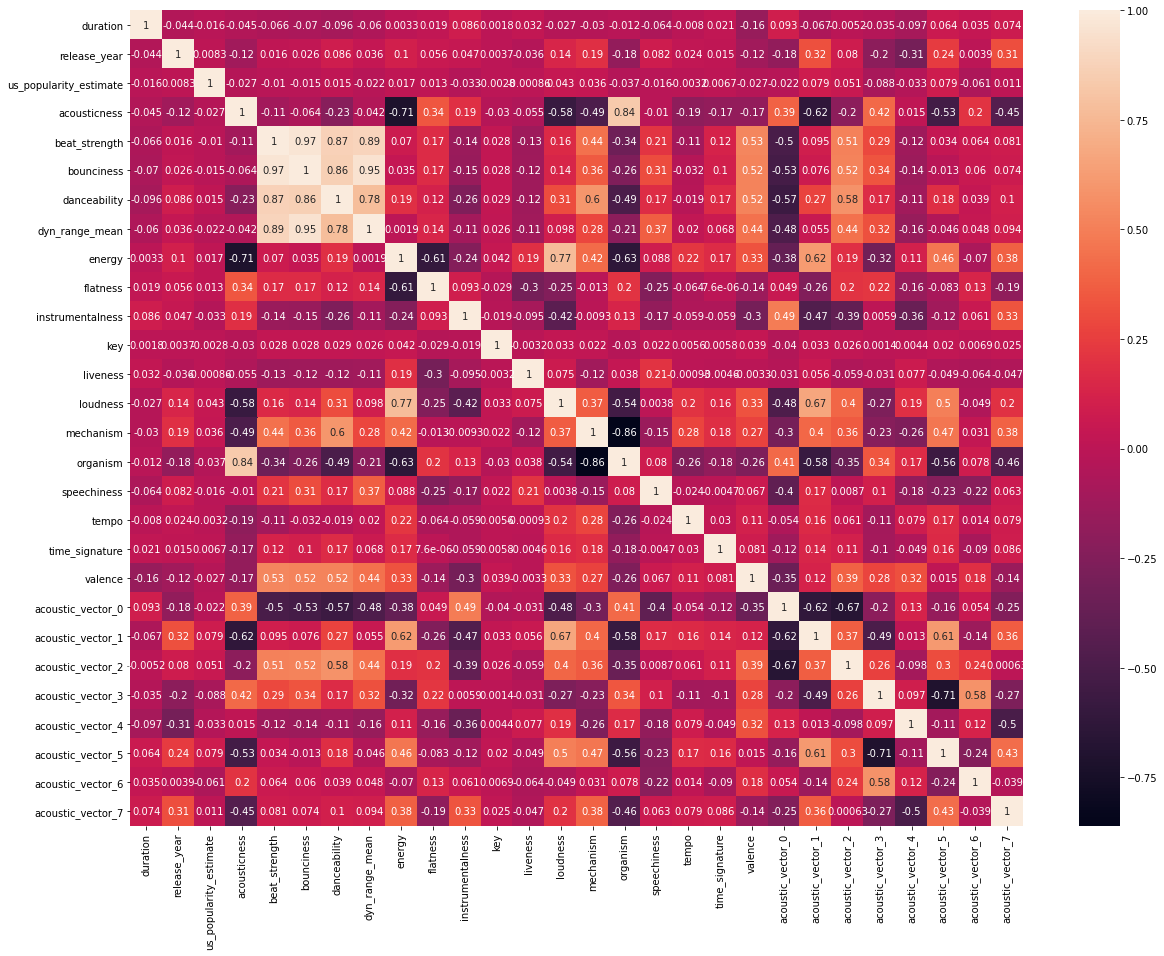

In [90]:
plt.figure(figsize=(20,15))
sns.heatmap(tf.corr(), annot=True);

### Merging track and Training Data on the basis of track_id (primary key):

In [91]:
track.shape

(3706388, 30)

In [92]:
df.shape

(167880, 17)

In [93]:
df.rename(columns={'track_id_clean': 'track_id'}, inplace=True)

In [94]:
final_train = pd.merge(df, track, on=['track_id'], left_index=True, right_index=False, sort=True)
final_train.shape

(167880, 46)

In [95]:
final_train.sort_values(axis=0, by=['session_id','session_position'], inplace=True)
final_train.reset_index(drop=True,inplace=True)

In [96]:
final_train.head()

,session_id,session_position,session_length,track_id,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,skip,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1.0,20.0,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.0,0.0,0.0,0.0,0.0,0.0,1,16.0,1,editorial_playlist,trackdone,trackdone,0,180.066666,2018,99.968133,0.015848,0.438551,0.473455,0.653119,7.660024,0.553465,1.035007,3.484468e-03,1,0.678553,-6.577,0.546784,1,0.320668,0.069717,134.024994,4,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2.0,20.0,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,editorial_playlist,trackdone,trackdone,0,236.796371,2018,99.896728,0.061811,0.654804,0.735661,0.877393,11.308750,0.726828,1.025636,1.031315e-07,7,0.104322,-5.319,0.824766,0,0.131391,0.061158,130.037994,4,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3.0,20.0,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,editorial_playlist,trackdone,trackdone,0,231.266663,2018,99.999976,0.354116,0.532155,0.540411,0.679719,8.065802,0.563009,1.029465,2.659035e-08,10,0.135776,-5.843,0.774327,1,0.296923,0.045354,145.028000,4,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4.0,20.0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,editorial_playlist,trackdone,trackdone,0,169.826675,2018,99.995038,0.769225,0.641756,0.729224,0.864881,11.287586,0.529484,0.993520,6.598388e-06,1,0.103722,-7.756,0.630996,1,0.603271,0.229936,111.982002,4,0.649420,-0.705116,0.317562,0.289141,-0.038920,-0.393358,0.092719,-0.364418,0.285603
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5.0,20.0,t_64f3743c-f624-46bb-a579-0f3f9a07a123,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,editorial_playlist,trackdone,trackdone,0,210.545258,2018,99.998498,0.006602,0.732428,0.794881,0.857778,12.181586,0.650057,1.000571,2.066649e-06,8,0.120842,-4.919,0.759465,1,0.170148,0.240980,147.031006,4,0.652921,-0.868489,0.331280,0.210478,0.084740,-0.333287,-0.025706,-0.510350,0.182315


In [97]:
ft = final_train.drop(columns=["session_id","track_id","key", 'time_signature'])
ft = pd.get_dummies(ft, drop_first=True)
ft.shape

(167880, 58)

In [98]:
ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   session_position                            167880 non-null  float64
 1   session_length                              167880 non-null  float64
 2   context_switch                              167880 non-null  float64
 3   no_pause_before_play                        167880 non-null  float64
 4   short_pause_before_play                     167880 non-null  float64
 5   long_pause_before_play                      167880 non-null  float64
 6   hist_user_behavior_n_seekfwd                167880 non-null  float64
 7   hist_user_behavior_n_seekback               167880 non-null  float64
 8   hist_user_behavior_is_shuffle               167880 non-null  int64  
 9   hour_of_day                                 167880 non-null  float64
 

### Modeling with only Training Data 

In [99]:
dummy_train.head(2)

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,skip,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone
0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1,16.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,2.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [100]:
dummy_train.shape

(167880, 34)

### Train Test Split 

In [101]:
X = dummy_train.drop(columns=["skip"])
y = dummy_train.skip

X_resampled, Y_resampled = SMOTE(sampling_strategy=1.0, random_state=2).fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, Y_resampled,
    test_size=0.2,
    random_state=2
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=2
)   

### Standardsing Data

In [103]:
scaler = StandardScaler()
sX_train = scaler.fit_transform(X_train)
sX_val = scaler.transform(X_val)
sX_test = scaler.transform(X_test)


# Applying LOgistic Regression
log = LogisticRegressionCV(
    cv=3
).fit(
    sX_train,
    y_train
)

print("Log Train score: %s" % log.score(sX_train,y_train))
print("Log Val score:   %s" % log.score(sX_val,y_val))
print("Log Test score:  %s" % log.score(sX_test,y_test))

Log Train score: 0.9896689314563947
Log Val score:   0.9885041435307905
Log Test score:  0.9885042076832072


###  Applying Random Forest

In [104]:
rfc = RandomForestClassifier(
    n_estimators=100
).fit(
    X_train,
    y_train
)

print("RFC Train score: %s" % rfc.score(X_train,y_train))
print("RFC Val score:   %s" % rfc.score(X_val,y_val))
print("RFC Test score:  %s" % rfc.score(X_test,y_test))

RFC Train score: 0.9976840548572067
RFC Val score:   0.989592343536371
RFC Test score:  0.9900444206343891


### Feature selection using Boruta 

In [105]:
!pip install boruta
from boruta import BorutaPy

     |████████████████████████████████| 61kB 2.8MB/s 


In [106]:
rf = RandomForestClassifier(random_state=1, n_estimators=100, max_depth=5)
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)   # initialize the boruta selector
boruta_selector.fit(np.array(sX_train), np.array(y_train))  

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	28
Tentative: 	2
Rejected: 	3
Iteration: 	9 / 100
Confirmed: 	28
Tentative: 	2
Rejected: 	3
Iteration: 	10 / 100
Confirmed: 	28
Tentative: 	2
Rejected: 	3
Iteration: 	11 / 100
Confirmed: 	28
Tentative: 	2
Rejected: 	3
Iteration: 	12 / 100
Confirmed: 	28
Tentative: 	2
Rejected: 	3
Iteration: 	13 / 100
Confirmed: 	28
Tentative: 	2
Rejected: 	3
Iteration: 	14 / 100
Confirmed: 	28
Tentative: 	2
Rejected: 	3
Iteration: 	15 / 100
Confirmed: 	28
Tentative: 	2
Rejected: 	3
Iteration: 	16 / 100
Confirmed: 	28
Tentative: 	2
Rejected: 	3
I

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=5, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=152, n_jobs=None,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7F4E4F4C5DB0,
                                          verbose=0, warm_start=False),
         max_iter=100, n_estimators='a

In [107]:
print("Selected Features: ", boruta_selector.support_)    # check selected features
print("Ranking: ",boruta_selector.ranking_)               # check ranking of features
print("No. of significant features: ", boruta_selector.n_features_)

Selected Features:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True False  True False  True
  True False  True False  True  True  True  True  True]
Ranking:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 3 1 4 1 1 5 1 6 1 1 1 1 1]
No. of significant features:  28


In [109]:
selected_rf_features = pd.DataFrame({'Feature':list(X.columns),
                                      'Ranking':boruta_selector.ranking_})
selected_rf_features.sort_values(by='Ranking')

,Feature,Ranking
0,session_position,1
30,hist_user_behavior_reason_end_logout,1
29,hist_user_behavior_reason_end_fwdbtn,1
28,hist_user_behavior_reason_end_endplay,1
26,hist_user_behavior_reason_end_backbtn,1
24,hist_user_behavior_reason_start_trackdone,1
23,hist_user_behavior_reason_start_remote,1
21,hist_user_behavior_reason_start_fwdbtn,1
19,hist_user_behavior_reason_start_clickrow,1
18,hist_user_behavior_reason_start_backbtn,1


In [110]:
X_important_train = boruta_selector.transform(np.array(X_train))
X_important_val = boruta_selector.transform(np.array(X_val))
X_important_test = boruta_selector.transform(np.array(X_test))

### Creating model with important features (selected by boruta)

In [111]:
rf_important = RandomForestClassifier(random_state=1, n_estimators=100, n_jobs = -1)
rf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [113]:
print("RFC Train score: %s" % rf_important.score(X_important_train, y_train))
print("RFC Val score:   %s" % rf_important.score(X_important_val, y_val))
print("RFC Test score:  %s" % rf_important.score(X_important_test, y_test)) 

RFC Train score: 0.9976770791188248
RFC Val score:   0.9898713691788276
RFC Test score:  0.9901113864148753


### Applying XG Boost

In [114]:
xg = xgb.XGBClassifier()
xg.fit(X_important_train, y_train,
       eval_set=[(X_important_train, y_train),(X_important_val, y_val)],
       early_stopping_rounds=10, verbose=True)   

[0]	validation_0-error:0.008092	validation_1-error:0.009571
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00812	validation_1-error:0.00971
[2]	validation_0-error:0.008064	validation_1-error:0.009571
[3]	validation_0-error:0.00812	validation_1-error:0.00971
[4]	validation_0-error:0.008064	validation_1-error:0.009571
[5]	validation_0-error:0.008029	validation_1-error:0.009682
[6]	validation_0-error:0.008029	validation_1-error:0.009682
[7]	validation_0-error:0.008029	validation_1-error:0.009682
[8]	validation_0-error:0.008029	validation_1-error:0.009682
[9]	validation_0-error:0.008029	validation_1-error:0.009682
[10]	validation_0-error:0.008029	validation_1-error:0.009682
Stopping. Best iteration:
[0]	validation_0-error:0.008092	validation_1-error:0.009571



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [115]:
print("XGB Train score: %s" % xg.score(X_important_train,y_train))
print("XGB Val score:   %s" % xg.score(X_important_val,y_val))
print("XGB Test score:  %s" % xg.score(X_important_test,y_test))

XGB Train score: 0.9919081434769871
XGB Val score:   0.9904294204637406
XGB Test score:  0.9910712292685104


### Testing  Model on the Data (given by technocolabs) 

In [116]:
# loading test data 
ts1 = pd.read_csv('/content/drive/MyDrive/test_data.csv')
ts2 = pd.read_csv('/content/drive/MyDrive/test_data_20.csv')

test_set = pd.concat([ts1,ts2])
test_set.shape

(202371, 40)

In [117]:
test_set.head(2)

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_end_appload,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone
0,63_0008bbc4-6368-4bf2-83d8-d7f5bf8e0df3,0.000000,0.5,t_c7703c28-9da6-41f3-89b7-1a86ff1ee6be,0,0,1,0,0,0,0,0,-0.164915,-0.165319,0,0.434783,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,63_0008bbc4-6368-4bf2-83d8-d7f5bf8e0df3,0.052632,0.5,t_c7703c28-9da6-41f3-89b7-1a86ff1ee6be,0,0,0,1,1,1,0,0,-0.164915,-0.165319,0,0.434783,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [118]:
test_set['skip'] =  test_set['not_skipped'].replace({ 0 : 1, 1 : 0 })
y_test_data = test_set.skip

In [119]:
t1 = test_set.drop(['skip_1','skip_2','skip', 'skip_3',	'not_skipped', 'session_id', 'track_id_clean','hist_user_behavior_reason_end_appload'], 
              axis=1)
t1.shape

(202371, 33)

#### Loading Validation data

In [120]:
vs1 = pd.read_csv('/content/drive/MyDrive/val_data.csv')
vs2 = pd.read_csv('/content/drive/MyDrive/val_data_20.csv')

val_set = pd.concat([vs1,vs2])
val_set.shape

(203816, 40)

In [121]:
val_set['skip'] =  val_set['not_skipped'].replace({ 0 : 1, 1 : 0 })
y_val_data = val_set.skip

In [122]:
v1 = val_set.drop(['skip_1','skip_2','skip', 'skip_3',	'not_skipped', 'session_id', 'track_id_clean', 'hist_user_behavior_reason_end_appload'],
             axis=1)
v1.shape

(203816, 33)

### Selecting relevent features from Test and Validation set by using Boruta 

In [123]:
X_val_set = boruta_selector.transform(np.array(v1))
X_test_set = boruta_selector.transform(np.array(t1))

### Validation and test score on unseen data

In [124]:
print("XGB Val score:   %s" % xg.score(X_val_set, y_val_data))
print("XGB Test score:  %s" % xg.score(X_test_set, y_test_data))

XGB Val score:   0.9888281587314048
XGB Test score:  0.988866981929229


In [125]:
print("RF Val score:   %s" % rf_important.score(X_val_set, y_val_data))
print("RF Test score:  %s" % rf_important.score(X_test_set, y_test_data))

RF Val score:   0.9890685716528633
RF Test score:  0.9890596972886432


### Creating Model with final data (merged data-- ie track + train data)

In [126]:
ft.head(2)

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,skip,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,liveness,loudness,mechanism,mode,organism,speechiness,tempo,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone
0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1,16.0,1,0,180.066666,2018,99.968133,0.015848,0.438551,0.473455,0.653119,7.660024,0.553465,1.035007,3.484468e-03,0.678553,-6.577,0.546784,1,0.320668,0.069717,134.024994,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,2.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,1,16.0,1,0,236.796371,2018,99.896728,0.061811,0.654804,0.735661,0.877393,11.308750,0.726828,1.025636,1.031315e-07,0.104322,-5.319,0.824766,0,0.131391,0.061158,130.037994,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [127]:
X = ft.drop(columns=["skip"])
y = ft.skip

In [128]:
X_resampled, Y_resampled = SMOTE(sampling_strategy=1.0, random_state=2).fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [129]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, Y_resampled,
    test_size=0.2,
    random_state=2
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=2
)

### Scaling Data

In [130]:
scaler = StandardScaler()
sX_train = scaler.fit_transform(X_train)
sX_val = scaler.transform(X_val)
sX_test = scaler.transform(X_test)


# Applying Logistic Regression
log = LogisticRegressionCV(
    cv=3
).fit(
    sX_train,
    y_train
)

print("Log Train score: %s" % log.score(sX_train,y_train))
print("Log Val score:   %s" % log.score(sX_val,y_val))
print("Log Test score:  %s" % log.score(sX_test,y_test))

Log Train score: 0.9893968776595002
Log Val score:   0.9881972153240883
Log Test score:  0.9879908033661465


### Applying Random forest Classifier

In [131]:
rfc = RandomForestClassifier(
    n_estimators=100
).fit(
    X_train,
    y_train
)

print("RFC Train score: %s" % rfc.score(X_train,y_train))
print("RFC Val score:   %s" % rfc.score(X_val,y_val))
print("RFC Test score:  %s" % rfc.score(X_test,y_test))

RFC Train score: 0.9999581455697085
RFC Val score:   0.9917129384190407
RFC Test score:  0.9920980379026317


### Feature selction using Boruta

In [132]:
rf = RandomForestClassifier(random_state=1, n_estimators=100, max_depth=5)
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)   # initialize the boruta selector
boruta_selector.fit(np.array(sX_train), np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	41
Tentative: 	16
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	41
Tentative: 	12
Rejected: 	4
Iteration: 	10 / 100
Confirmed: 	41
Tentative: 	12
Rejected: 	4
Iteration: 	11 / 100
Confirmed: 	41
Tentative: 	12
Rejected: 	4
Iteration: 	12 / 100
Confirmed: 	44
Tentative: 	9
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	44
Tentative: 	9
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	44
Tentative: 	9
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	44
Tentative: 	9
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	45
Tentative: 	8
Rejected: 

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=5, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=203, n_jobs=None,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7F4E4F4C5CA8,
                                          verbose=0, warm_start=False),
         max_iter=100, n_estimators='a

In [133]:
print("Selected Features: ", boruta_selector.support_)    # check selected features
print("Ranking: ",boruta_selector.ranking_)               # check ranking of features
print("No. of significant features: ", boruta_selector.n_features_)

Selected Features:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True False
  True  True False False  True  True  True  True  True]
Ranking:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 3 1 4 1 1 5 6 1 1 1 1 1]
No. of significant features:  52


In [134]:
selected_rf_features = pd.DataFrame({'Feature':list(X.columns),
                                      'Ranking':boruta_selector.ranking_})
selected_rf_features.sort_values(by='Ranking')

,Feature,Ranking
0,session_position,1
55,hist_user_behavior_reason_end_remote,1
29,valence,1
30,acoustic_vector_0,1
31,acoustic_vector_1,1
32,acoustic_vector_2,1
33,acoustic_vector_3,1
34,acoustic_vector_4,1
35,acoustic_vector_5,1
36,acoustic_vector_6,1


### Model with important features

In [135]:
X_important_train = boruta_selector.transform(np.array(X_train))
X_important_val = boruta_selector.transform(np.array(X_val))
X_important_test = boruta_selector.transform(np.array(X_test))

### Random Forest

In [136]:
rf_important = RandomForestClassifier(random_state=1, n_estimators=100, n_jobs = -1)
rf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [137]:
print("RFC Train score: %s" % rf_important.score(X_important_train, y_train))
print("RFC Val score:   %s" % rf_important.score(X_important_val, y_val))
print("RFC Test score:  %s" % rf_important.score(X_important_test, y_test)) 

RFC Train score: 0.9999860485232361
RFC Val score:   0.991852451240269
RFC Test score:  0.9921203598294605


### XG Boost

In [138]:
xg = xgb.XGBClassifier()
xg.fit(X_important_train, y_train,
       eval_set=[(X_important_train, y_train),(X_important_val, y_val)],
       early_stopping_rounds=10, verbose=True)

[0]	validation_0-error:0.007973	validation_1-error:0.009654
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.007973	validation_1-error:0.009654
[2]	validation_0-error:0.007952	validation_1-error:0.009682
[3]	validation_0-error:0.007952	validation_1-error:0.009682
[4]	validation_0-error:0.007952	validation_1-error:0.009682
[5]	validation_0-error:0.007952	validation_1-error:0.009682
[6]	validation_0-error:0.007952	validation_1-error:0.009682
[7]	validation_0-error:0.007959	validation_1-error:0.009682
[8]	validation_0-error:0.007952	validation_1-error:0.009682
[9]	validation_0-error:0.007952	validation_1-error:0.009682
[10]	validation_0-error:0.007938	validation_1-error:0.009682
Stopping. Best iteration:
[0]	validation_0-error:0.007973	validation_1-error:0.009654



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [139]:
print("XGB Train score: %s" % xg.score(X_important_train,y_train))
print("XGB Val score:   %s" % xg.score(X_important_val,y_val))
print("XGB Test score:  %s" % xg.score(X_important_test,y_test)) 

XGB Train score: 0.9920267310294795
XGB Val score:   0.9903457127710037
XGB Test score:  0.9909149757807094


### LGBM 

In [140]:
lgbm = LGBMClassifier( ).fit( X_important_train, y_train,
       eval_set=[(X_important_train, y_train),(X_important_val, y_val)],
       early_stopping_rounds=10, verbose=True)

print()
print("LGBM Train score: %s" % lgbm.score(X_important_train,y_train))
print("LGBM Val score:   %s" % lgbm.score(X_important_val,y_val))
print("LGBM Test score:  %s" % lgbm.score(X_important_test,y_test))

[1]	training's binary_logloss: 0.600579	valid_1's binary_logloss: 0.600919
Training until validation scores don't improve for 10 rounds.
[2]	training's binary_logloss: 0.524782	valid_1's binary_logloss: 0.525417
[3]	training's binary_logloss: 0.461593	valid_1's binary_logloss: 0.462514
[4]	training's binary_logloss: 0.408229	valid_1's binary_logloss: 0.409416
[5]	training's binary_logloss: 0.362778	valid_1's binary_logloss: 0.36425
[6]	training's binary_logloss: 0.323563	valid_1's binary_logloss: 0.325281
[7]	training's binary_logloss: 0.289599	valid_1's binary_logloss: 0.291545
[8]	training's binary_logloss: 0.260109	valid_1's binary_logloss: 0.262291
[9]	training's binary_logloss: 0.23418	valid_1's binary_logloss: 0.236562
[10]	training's binary_logloss: 0.211531	valid_1's binary_logloss: 0.214129
[11]	training's binary_logloss: 0.191533	valid_1's binary_logloss: 0.194321
[12]	training's binary_logloss: 0.173899	valid_1's binary_logloss: 0.176916
[13]	training's binary_logloss: 0.158

In [141]:
y_pred = lgbm.predict(X_important_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     22340
           1       1.00      0.99      0.99     22459

    accuracy                           0.99     44799
   macro avg       0.99      0.99      0.99     44799
weighted avg       0.99      0.99      0.99     44799



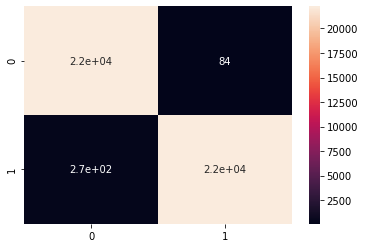

In [143]:
# draw classification report and confusion matrix  for LGBM MODEL (BASE MODEL)
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True)

In [144]:
import pickle
pickle.dump(lgbm, open("lbm.pkl", 'wb'))
pickle.dump(xg, open("xg.pkl", 'wb'))
pickle.dump(rf_important, open("rf.pkl", 'wb'))

<h2 align='center'> THANK YOU </h2>